In [15]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: images/bhuvneshwar_kumar/0061d197a2.jpg  
  inflating: images/bhuvneshwar_kumar/0389b4a1bc.jpg  
  inflating: images/bhuvneshwar_kumar/045c0e444e.jpg  
  inflating: images/bhuvneshwar_kumar/15352f9af1.jpg  
  inflating: images/bhuvneshwar_kumar/1678a74ac1.jpg  
  inflating: images/bhuvneshwar_kumar/263f97b2ec.jpg  
  inflating: images/bhuvneshwar_kumar/2cc088e3ca.jpg  
  inflating: images/bhuvneshwar_kumar/2ef3709518.jpg  
  inflating: images/bhuvneshwar_kumar/44f8baa47d.jpg  
  inflating: images/bhuvneshwar_kumar/460915ed52.jpg  
  inflating: images/bhuvneshwar_kumar/51f67e6a92.jpg  
  inflating: images/bhuvneshwar_kumar/5552c950a8.jpg  
  inflating: images/bhuvneshwar_kumar/598ddc2d27.jpg  
  inflating: images/bhuvneshwar_kumar/5f365dc4af.jpg  
  inflating: images/bhuvneshwar_kumar/60627ea0c0.jpg  
  inflating: images/bhuvneshwar_kumar/64f5826ff0.jpg  
  inflating: images/bhuvneshwar_kumar/67edab4c01.jpg  
  inflating: images/bhuvneshwar_kumar/6adde

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

Number Of Players    :  15
Number Of Images     :  576


Distribution Per Player


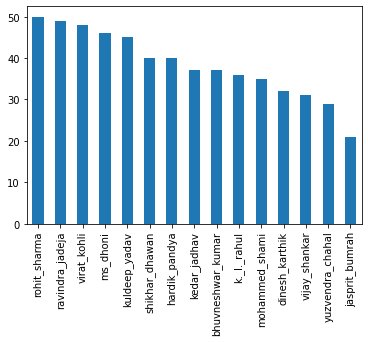

In [ ]:
ds = pd.read_csv("players.csv")
ds = ds.sample(frac=1).reset_index(drop=True)

le = preprocessing.LabelEncoder()
le.fit(ds['player'])
ds['player_trans'] = le.transform(ds['player'])

n = int(len(ds))
players = ds.player.nunique()
print("Number Of Players    : ",players)
print("Number Of Images     : ",n)
print("\n\nDistribution Per Player")
ds['player'].value_counts().plot.bar()

ds = ds[:-6]
test = ds[-6:]

RESIZING DATA

Distribution Per Player


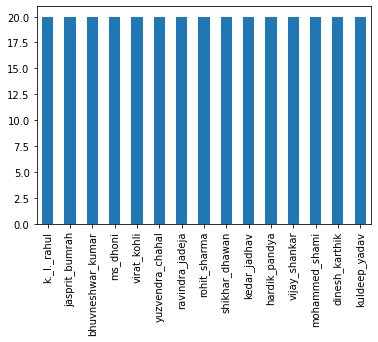

In [ ]:
for index,row in ds.iterrows():
    if len(ds[ds['player']==row['player']])>20:
        ds.drop(ds[ds['image']==row['image']].index , inplace=True)

print("Distribution Per Player")
ds['player'].value_counts().plot.bar()

DATA AUGMENTATION

In [ ]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:image = tf.image.transpose(image)
    if p_rotate > .75:image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:image = tf.image.rot90(image, k=1) 

    if p_pixel_1 >= .4:image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:image = tf.image.random_brightness(image, max_delta=.1)

    if p_crop > .7:
        if p_crop > .9:image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:image = tf.image.central_crop(image, central_fraction=.8)
        else:image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(224*.8),224, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    image = tf.image.resize(image, [224,224])
    return image,label

def load_img(image,player,player_transf):
    path = "images/"+player+"/"+image
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img,player_transf
dataset = tf.data.Dataset.from_tensor_slices((ds.image.values,ds.player.values,ds.player_trans.values))

In [ ]:
train_ds = dataset.take(int(0.8*n))
val_ds = dataset.skip(int(0.8*n))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(load_img,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat(40).map(data_augment,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(players, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
checkpoint_path = "./checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

70% TRAIN DATA, 30% TEST DATA

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=val_ds,verbose=1,callbacks=[cp_callback])

Epoch 1/20
375/375 [==============================] - 380s 1s/step - loss: 2.0545 - accuracy: 0.3761

Epoch 00001: saving model to ./checkpoints/cp.ckpt
Epoch 2/20
375/375 [==============================] - 375s 999ms/step - loss: 0.7452 - accuracy: 0.8328

Epoch 00002: saving model to ./checkpoints/cp.ckpt
Epoch 3/20
375/375 [==============================] - 371s 989ms/step - loss: 0.4691 - accuracy: 0.9037

Epoch 00003: saving model to ./checkpoints/cp.ckpt
Epoch 4/20
375/375 [==============================] - 368s 981ms/step - loss: 0.3175 - accuracy: 0.9482

Epoch 00004: saving model to ./checkpoints/cp.ckpt
Epoch 5/20
375/375 [==============================] - 374s 996ms/step - loss: 0.2514 - accuracy: 0.9591

Epoch 00005: saving model to ./checkpoints/cp.ckpt
Epoch 6/20
375/375 [==============================] - 369s 983ms/step - loss: 0.1914 - accuracy: 0.9715

Epoch 00006: saving model to ./checkpoints/cp.ckpt
Epoch 7/20
375/375 [==============================] - 369s 982ms/st

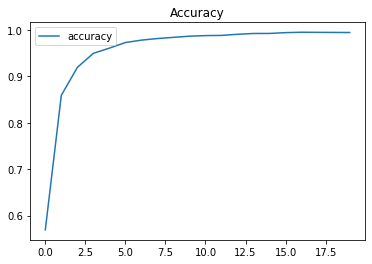

In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

ACCURACY ACHEIVED: 0.9952

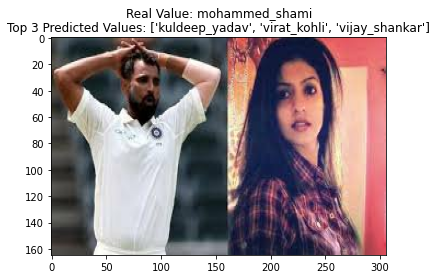

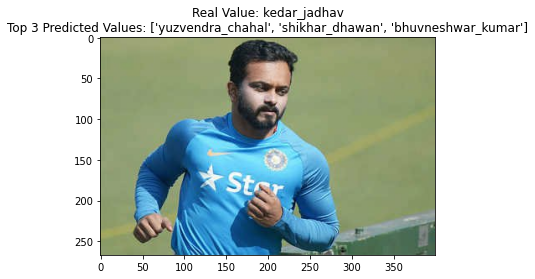

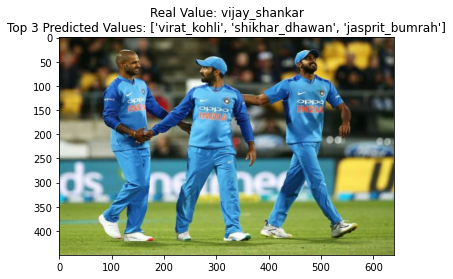

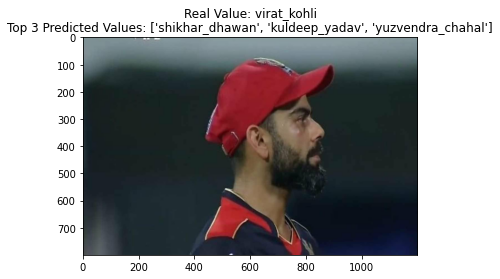

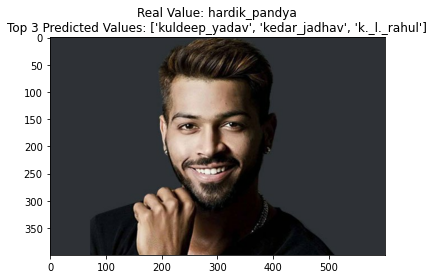

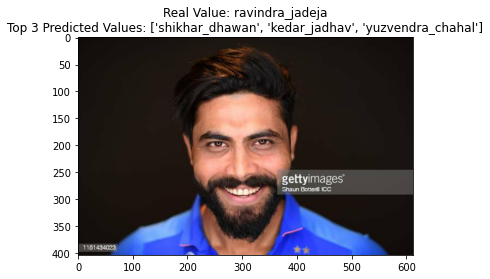

In [ ]:
i=0 
def load_test_img(image,player,player_transf):
    path = "/content/images/"+player+"/"+image 
    img = tf.io.decode_jpeg(tf.io.read_file(path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img

test_ds = tf.data.Dataset.from_tensor_slices((test.image.values,test.player.values,test.player_trans.values))
test_ds = test_ds.map(load_test_img).batch(6)
prediction = model.predict(test_ds)

for index,row in test.iterrows():
    img = tf.io.decode_jpeg(tf.io.read_file("/content/images/"+row['player']+"/"+row['image']),channels=3)
    imgplot = plt.imshow(img.numpy().astype("uint8"),aspect='auto')
    real = str(list(le.classes_)[row['player_trans']])
    top_k_values, top_k_indices = tf.nn.top_k(prediction[i], k=3)
    top_k_names = []
    for k in range(3):
        top_k_names+=[str(list(le.classes_)[top_k_indices[k]])]
    plt.title("Real Value: "+str(real)+"\nTop 3 Predicted Values: "+str(top_k_names))
    plt.show()
    i+=1

LEVEL 2

In [ ]:
import cv2

# Face Detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
 
# Init Camera


cap = cv2.VideoCapture(0)
while True:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    _, frame = cap.read()
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    if faces is ():
        print("No Face Detected")
        
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.imshow('img', frame)

    exitKey = cv2.waitKey(30) & 0xFF
    if exitKey==27:
        break
        
cap.release()
cv2.destroyAllWindows()
